In [1]:
pip install torchvision

In [2]:
import torchvision
import torchvision.transforms as transforms

train_data = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)

test_data = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5056720.81it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 58967.90it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1272281.87it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4500479.27it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(1, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 1, 3, 1, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 3, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [4]:
for i in range(10):
  print(train_data[i][0].shape)

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


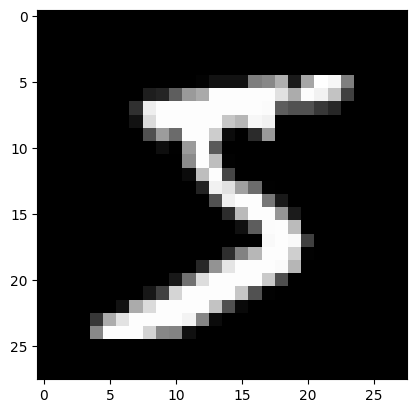

In [5]:
# from PIL import Image
# img = Image.fromarray(train_data[0][0].numpy(), '')
# img.show()

import matplotlib.pyplot as plt
plt.imshow(train_data[0][0].numpy().reshape(28,28,1), cmap = 'gray')
plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
from torch.optim import Adam

gen = Generator().to(device)
dis = Discriminator().to(device)

loss_f = nn.BCELoss().to(device)

opt_gen = Adam(gen.parameters(), lr=1e-3, betas = (0.5, 0.999))
opt_dis = Adam(dis.parameters(), lr=1e-3, betas = (0.5, 0.999))

transform = transforms.Compose([
    transforms.Resize((256,256)),
])

batch_size = 4

epochs = 10

for epoch in range(epochs):
  for i in range(len(train_data)):
        real_image = train_data[i][0]
        real_image = real_image.unsqueeze(0).to(device)

        #Training Discriminator
        opt_dis.zero_grad()
        latent_vector = torch.randn(batch_size, 1, 7, 7).to(device)
        fake_image = gen(latent_vector).to(device)

        # Compute loss for real and fake
        real_prob = dis(real_image).to(device)
        loss_real = loss_f(real_prob, torch.ones_like(real_prob).to(device))

        fake_prob = dis(fake_image.detach()).to(device)
        loss_fake = loss_f(fake_prob, torch.zeros_like(fake_prob).to(device))

        # Backward pass for Discriminator
        loss_dis = loss_real + loss_fake
        loss_dis.backward()
        opt_dis.step()

        # Train Generator
        opt_gen.zero_grad()
        output = dis(fake_image).to(device)  # Get discriminator's prediction on fake images
        loss_gen = loss_f(output, torch.ones_like(output).to(device))  # Want fake images to be classified as real
        loss_gen.backward()
        opt_gen.step()

        # print(fake_image.shape)
    # plt.imshow(fake_image.detach().numpy().reshape(28,28,1), cmap = 'gray')
    # plt.show()
    # break
  print(f"Epoch: {epoch+1}/10")
  # break


Epoch: 1/10
Epoch: 2/10
Epoch: 3/10
Epoch: 4/10
Epoch: 5/10
Epoch: 6/10
Epoch: 7/10
Epoch: 8/10
Epoch: 9/10
Epoch: 10/10


In [8]:
torch.save(gen.state_dict(), 'mnsit1.pth')

<ipython-input-19-ab0b4ad39d75>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mnsit1.pth"))


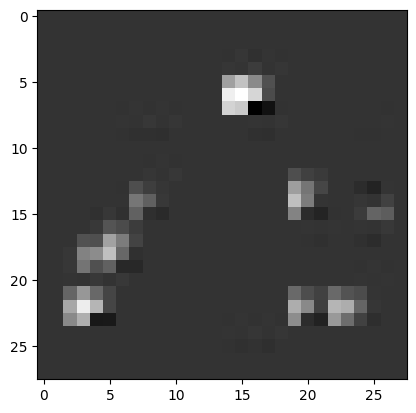

In [19]:
model = Generator().to(device)
model.load_state_dict(torch.load("mnsit1.pth"))
model.eval()
z = torch.randn(1, 1, 7, 7).to(device)
output = model(z).cpu()
plt.imshow(output.detach().numpy().reshape(28,28,1), cmap = 'gray')
plt.show()